In [85]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

import sklearn
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.metrics import accuracy_score,f1_score
from sklearn.svm import SVC
from bayes_opt import BayesianOptimization
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier

from tpot import TPOTClassifier
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import RFE

## Config

In [100]:
TRAIN_TEST_SPLIT = True

DROPPED_FAULTY_ENTRIES = True


## Data import

In [158]:
# Data Read
df_train = pd.read_csv('../../data/raw/teco-psda-exercisesheet1-employment-2024/employment_train.csv')
df_test = pd.read_csv('../../data/raw/teco-psda-exercisesheet1-employment-2024/employment_test.csv')

# Compare Columns to Desc
print(df_test.columns)
print(df_train.columns)

Index(['Unnamed: 0', 'age', 'race', 'earnwke', 'married', 'union', 'ne_states',
       'so_states', 'ce_states', 'we_states', 'government', 'private', 'self',
       'educ_lths', 'educ_hs', 'educ_somecol', 'educ_aa', 'educ_bac',
       'educ_adv', 'female'],
      dtype='object')
Index(['Unnamed: 0', 'age', 'race', 'earnwke', 'employed', 'unemployed',
       'married', 'union', 'ne_states', 'so_states', 'ce_states', 'we_states',
       'government', 'private', 'self', 'educ_lths', 'educ_hs', 'educ_somecol',
       'educ_aa', 'educ_bac', 'educ_adv', 'female'],
      dtype='object')


In [159]:
#print(df_train.describe())  

#df_train["race"] = df_train["race"].astype("category")
#df_train["married"] = df_train["married"].astype("category")
#df_train["union"] = df_train["union"].astype("category")
#df_train["government"] = df_train["government"].astype("category")
#df_test["private"] = df_test["private"].astype("category")
#df_test["earnwke"] = df_test["earnwke"].astype("object")

In [220]:
df_sample = pd.read_csv(filepath_or_buffer = '../../data/raw/teco-psda-exercisesheet1-employment-2024/employment_test_sample.csv')

In [221]:
print(df_sample.describe())
print(df_sample.columns)
print(df_sample.head())
print(df_sample[:2])
print(type(df_sample))
print(df_sample.loc[:,"Category"])

                Id  Category
count   200.000000     200.0
mean   2821.615000       1.0
std    1462.174235       0.0
min      43.000000       1.0
25%    1557.750000       1.0
50%    3077.500000       1.0
75%    4031.250000       1.0
max    5338.000000       1.0
Index(['Id', 'Category'], dtype='object')
   Id  Category
0  43         1
1  45         1
2  64         1
3  86         1
4  94         1
   Id  Category
0  43         1
1  45         1
<class 'pandas.core.frame.DataFrame'>
0      1
1      1
2      1
3      1
4      1
      ..
195    1
196    1
197    1
198    1
199    1
Name: Category, Length: 200, dtype: int64


In [222]:
for i in range(0,200):
    df_sample.loc[i,"Category"] = 0 
    #print(df_sample.loc[i,"Category"])
print(df_sample.head())    

   Id  Category
0  43         0
1  45         0
2  64         0
3  86         0
4  94         0


In [223]:
df_sample.to_csv(path_or_buf='../../data/raw/teco-psda-exercisesheet1-employment-2024/employment_test_generated.csv',index = False)

## Data exploration

In [160]:
# First Look at the data


train = df_train.values
train_ids = train[:, 0]
train_employed = train[:, 4]
train_unemployed = train[:, 5]
train_data = train[:,np.array([not i == 4 and  not i == 5  for i in range(1,23)])]
test = df_test.values 

print("Amount of entries and features of training data:", train.shape)
print("Amount of entries:", train_ids.shape)
print("Entry count for employed classification:",train_employed.shape)
print("Amount of entries and features of testing data:", train_data.shape)
print("Amount of entries and features for the final testing data:", test.shape)

print("Amount of missing values: ", df_train.isnull().sum())
## only values which are "zero" are for those who have no weekly income which seems logical in regard to employment

print(df_train.describe())

Amount of entries and features of training data: (5212, 22)
Amount of entries: (5212,)
Entry count for employed classification: (5212,)
Amount of entries and features of testing data: (5212, 20)
Amount of entries and features for the final testing data: (200, 20)
Amount of missing values:  Unnamed: 0        0
age               0
race              0
earnwke         605
employed          0
unemployed        0
married           0
union             0
ne_states         0
so_states         0
ce_states         0
we_states         0
government        0
private           0
self              0
educ_lths         0
educ_hs           0
educ_somecol      0
educ_aa           0
educ_bac          0
educ_adv          0
female            0
dtype: int64
        Unnamed: 0          age         race     employed   unemployed  \
count  5212.000000  5212.000000  5212.000000  5212.000000  5212.000000   
mean   2701.044321    42.123177     1.226401     0.889870     0.040292   
std    1566.134437    11.358779   

In [172]:
print("Amount of employed individuals in data set:", train[:,4].sum())
print("By percentage:", ((train[:,4].sum())/(len(train[:,4]))))
print("Amount of unemployed individuals in data set: ", train[:,5].sum())
print("By percentage:", ((train[:,5].sum())/(len(train[:,5]))))

ctr_00 = 0
ctr_11 = 0
age_array = []

ctr_50 = 0
ctr_51 = 0
ctr_40 = 0
ctr_41 = 0

#Test for completeness of data
for i in range(0, len(train[:,5])):
    if train[i, 5] == 1: ctr_51 += 1
    if train[i, 5] == 0: ctr_50 += 1
    if train[i, 4] == 1: ctr_41 += 1
    if train[i, 4] == 0: ctr_40 += 1   
print("Für Unemployment 0: ",ctr_50,"1: ",ctr_51,"Summe: ",ctr_50 + ctr_51)
print("Für Employment 0: ",ctr_40,"1: ",ctr_41,"Summe: ",ctr_40 + ctr_41)


#Comparing of employed & unemployed for nonsensical data
for i in range(0, len(train[:,4])):
    if train[i,4] == train[i,5]:
        if train[i,4] == 0: ctr_00 += 1
        if train[i,4] == 1: ctr_11 += 1
        age_array += [train[i,1]]
        #print(train[i,0:6])
print("Amount of anomalistic entries in regard to age: ",len(age_array))
print("Neither aka 00:", ctr_00)
print("Both aka 11:", ctr_11)

#Check for edge cases in regard to the working age and the age of maturity 
child_ctr = 0
for i in range(0, len(train[:,4])):
    if train[i,1] < 18: 
        child_ctr += 1

print("Amount of children in the data:", child_ctr)


ctr_1000 = 0
ctr_0111 = 0
job_array = []

for i in range(0, len(train[:,4])):
    # Check if employed w/o prev anomalies
    if train[i,4] == 1 & train[i,4] != train[i,5]:
         if train[i,12] == 0 and train[i,13] == 0 and train[i,14] == 0:
            ctr_1000 += 1
            job_array += [train[i,1]]
            print(train[i,0],train[i,4],train[i,12:15])
    if train[i,4] == 0 & train[i,4] != train[i,5]:
        if train[i,12] == 0 or train[i,13] == 0 or train[i,14] == 0:
            ctr_0111 += 1
            job_array += [train[i,1]]
            print(train[i,0],train[i,4],train[i,12:15])
    
                
print("Amount of anomalistic entries in regard to employer: ",len(job_array))
print("Has a job but neither private nor governmental:", ctr_1000)
print("No job but still employed 011:", ctr_0111)






Amount of employed individuals in data set: 4638
By percentage: 0.8898695318495778
Amount of unemployed individuals in data set:  210
By percentage: 0.04029163468917882
Für Unemployment 0:  5002 1:  210 Summe:  5212
Für Employment 0:  574 1:  4638 Summe:  5212
Amount of anomalistic entries in regard to age:  364
Neither aka 00: 364
Both aka 11: 0
Amount of children in the data: 0
22 0 [0 1 0]
53 0 [0 1 0]
66 0 [0 1 0]
85 0 [0 1 0]
99 0 [0 1 0]
104 0 [0 1 0]
116 0 [0 1 0]
130 0 [0 1 0]
141 0 [0 1 0]
169 0 [0 1 0]
185 0 [0 1 0]
201 0 [0 1 0]
208 0 [0 1 0]
228 0 [0 1 0]
229 0 [0 1 0]
248 0 [0 1 0]
269 0 [0 1 0]
293 0 [0 1 0]
340 0 [0 1 0]
350 0 [0 1 0]
379 0 [0 1 0]
427 0 [0 1 0]
448 0 [0 1 0]
462 0 [0 1 0]
479 0 [0 1 0]
497 0 [0 0 1]
515 0 [1 0 0]
577 0 [0 1 0]
600 0 [0 1 0]
639 0 [0 1 0]
656 0 [0 1 0]
685 0 [0 1 0]
763 0 [1 0 0]
797 0 [0 1 0]
812 0 [0 1 0]
819 0 [0 1 0]
822 0 [0 1 0]
826 0 [0 1 0]
848 0 [0 1 0]
904 0 [0 1 0]
908 0 [0 1 0]
928 0 [0 1 0]
934 0 [0 1 0]
998 0 [0 1 0]
1045 0

Observations:  <br>
There are faulty entries in the data for which there hasn't been found  of yet a valid theory.  <br>
Furthermore there aren't any children in the data which could explain these anomalies.   

In [101]:
# List of IDs of faulty entries
if DROPPED_FAULTY_ENTRIES:    
    fEntriesIDs = []
    for i in range(0,len(train[:,4])):
        if train[i,4] == train[i,5]:
            fEntriesIDs += [i]
        
#print(fEntriesIDs)    
print(type(train_data))

<class 'numpy.ndarray'>


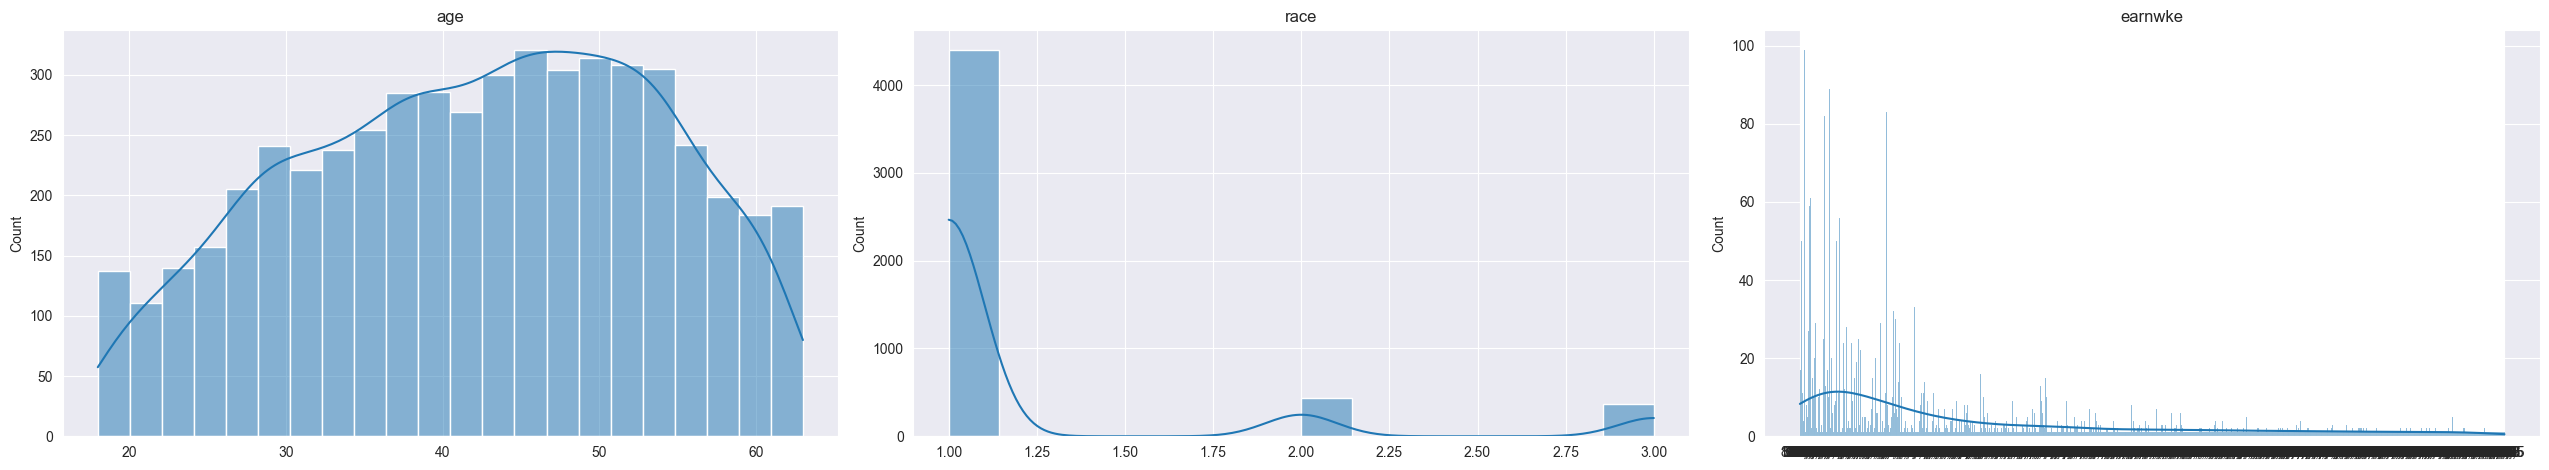

In [140]:
## Temporäre Ergänzung zur besseren Teambesprechung 

# Data Visualization
# Plot histograms for continuous variables

continuous_cols = ['age', 'race', 'earnwke']


plt.figure(figsize=(25.6, 4.8))
for i, col in enumerate(continuous_cols, 1):
    plt.subplot(1, 3, i)#2, 3, i
    sns.histplot(train[:,i],kde = True)
    plt.title(col)
plt.tight_layout()
plt.show()

In [147]:
# Plot count plots for categorical variables
categorical_cols = ['employed', 'unemployed', 'married', 'union', 'ne_states', 'so_states', 'ce_states', 'we_states', 'government', 'private', 'self', 'educ_lths', 'educ_hs', 'educ_somecol', 'educ_aa', 'educ_bac', 'educ_adv', 'female']

plt.figure(figsize=(25.6, 9.6))
for i, col in enumerate(categorical_cols, 1):
    plt.subplot(3,6,i)
    sns.countplot(train[:,i+3])
    plt.title(col)  
plt.tight_layout()
plt.show()

KeyboardInterrupt: 

Notes: 

<s>Current understanding is that employed & unemployed are NOT exclusive</s>

After contemplation certain sets do not make sense, therefore I will remove such nonsensical data entries
 

## Encoding & Train Test Split

In [24]:
#No encoding since gender, employment status, educ, states and such are already encoded

#Splitting
if TRAIN_TEST_SPLIT:
    temp_train_ids, temp_test_ids, temp_train_data, temp_test_data, temp_train_employed, temp_test_employed = train_test_split(train_ids, train_data, train_employed, test_size=50, random_state=4)
else: temp_train_ids, temp_train_data, temp_test_employed = train_ids, train_data, train_employed

# Removed temporarily

## Preprocessing the data 

In [111]:
snv = sklearn.preprocessing.StandardScaler()
prep_temp_train_data = snv.fit_transform(temp_train_data)
prep_temp_test_data = snv.transform(temp_test_data)


#print(temp_train_data)
#print(prep_temp_train_data)


[[5061 20 1 ... 0 0 0]
 [1704 51 1 ... 0 1 0]
 [258 39 1 ... 1 0 0]
 ...
 [2567 18 1 ... 0 0 1]
 [182 30 1 ... 0 0 0]
 [1178 58 1 ... 0 0 0]]
[[ 1.5071689  -1.94993079 -0.40235989 ... -0.53389005 -0.38155428
  -0.97210529]
 [-0.6353114   0.78098603 -0.40235989 ... -0.53389005  2.6208591
  -0.97210529]
 [-1.55816707 -0.27614306 -0.40235989 ...  1.87304483 -0.38155428
  -0.97210529]
 ...
 [-0.08453377 -2.12611897 -0.40235989 ... -0.53389005 -0.38155428
   1.02869515]
 [-1.60667124 -1.06898988 -0.40235989 ... -0.53389005 -0.38155428
  -0.97210529]
 [-0.97101132  1.39764466 -0.40235989 ... -0.53389005 -0.38155428
  -0.97210529]]


## Data visualization 

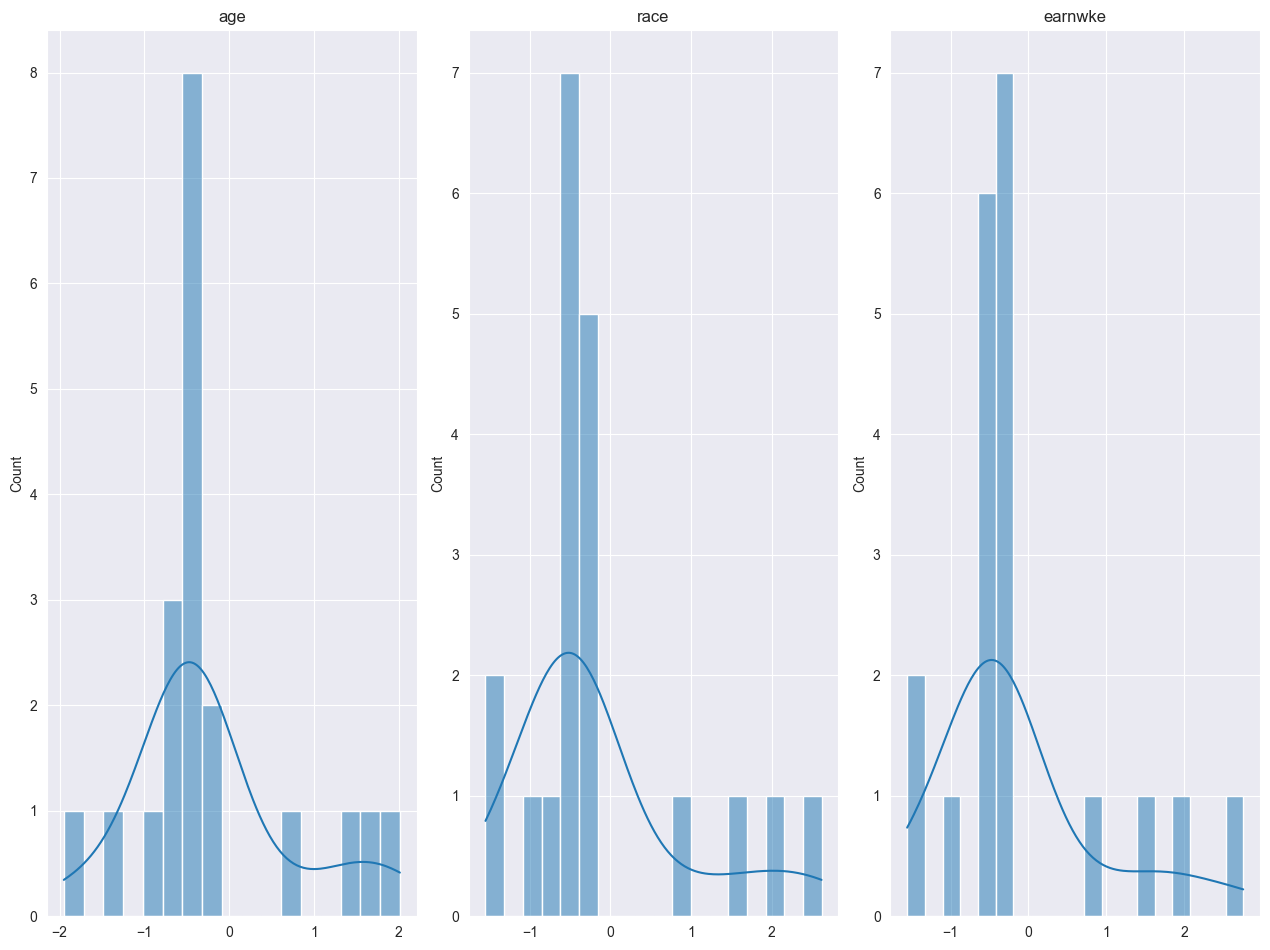

In [122]:
## Temporäre Ergänzung zur besseren Teambesprechung 

# Data Visualization
# Plot histograms for continuous variables

continuous_cols = ['age', 'race', 'earnwke']

j = 0
plt.figure(figsize=(12.8, 9.6))
for i, col in enumerate(continuous_cols, 1):
    plt.subplot(1, 3, i)#2, 3, i
    if col in continuous_cols: sns.histplot(prep_temp_train_data[j], kde=True)
    plt.title(col)
    j +=1
plt.tight_layout()
plt.show()

# Plot count plots for categorical variables
categorical_cols = ['employed', 'unemployed', 'married', 'union', 'ne_states', 'so_states', 'ce_states', 'we_states', 'government', 'private', 'self', 'educ_lths', 'educ_hs', 'educ_somecol', 'educ_aa', 'educ_bac', 'educ_adv', 'female']

#j = 0
#plt.figure(figsize=(25.6, 19.2))
#for i, col in enumerate(categorical_cols, 1):
#    plt.subplot()#4, 3, i
#    if col in categorical_cols:sns.countplot(data=prep_temp_train_data, x=j)
#    plt.title(col)
#    j +=1    
#plt.tight_layout()
#plt.show()


In [65]:
#train_partial = train[:, 1:5]
#df_cols = ['age', 'race', 'earnwke', 'employed']
#traind_df = pd.DataFrame([{'age':train_partial[:,0], 'race':train_partial[:,1], 'earnwke':train_partial[:,2], 'employed':train_partial[:,3]}])


#sns.pairplot(traind_df, hue ='employed')
#plt.suptitle('Pair Plot of continous features by deny (target variable)', y=1.02)
#plt.show()

In [79]:
knn_classifier = KNeighborsClassifier()
knn_classifier.fit(prep_temp_train_data, temp_train_employed.astype(bool))

KNeighborsClassifier()

In [83]:
temp_test_employed_pred = knn_classifier.predict(prep_temp_test_data)

print("Accuracy",sklearn.metrics.accuracy_score(temp_test_employed.astype(bool), temp_test_employed_pred))
print("F1-Score",sklearn.metrics.f1_score (temp_test_employed.astype(bool), temp_test_employed_pred))

Accuracy 0.94
F1-Score 0.9690721649484536


In [89]:
gaussian_process_classifier = GaussianProcessClassifier()
gaussian_process_classifier.fit(prep_temp_train_data, temp_train_employed.astype(bool))

GaussianProcessClassifier()

In [90]:
temp_test_employed_pred = gaussian_process_classifier.predict(prep_temp_test_data)

print("Accuracy",sklearn.metrics.accuracy_score(temp_test_employed.astype(bool), temp_test_employed_pred))
print("F1-Score",sklearn.metrics.f1_score (temp_test_employed.astype(bool), temp_test_employed_pred))

Accuracy 0.92
F1-Score 0.9583333333333334


In [91]:
svc = SVC()#kernel='linear'
svc.fit(prep_temp_train_data, temp_train_employed.astype(bool))

SVC()

In [92]:
temp_test_employed_pred = svc.predict(prep_temp_test_data)

print("Accuracy",sklearn.metrics.accuracy_score(temp_test_employed.astype(bool), temp_test_employed_pred))
print("F1-Score",sklearn.metrics.f1_score (temp_test_employed.astype(bool), temp_test_employed_pred))

Accuracy 0.94
F1-Score 0.9690721649484536


In [101]:
def hyperparameter_function_svc(gamma, C):
    """ Function for hyperparameter optimization
    """
    svc = SVC(gamma=gamma, C=C)
    svc.fit(prep_temp_train_data, temp_train_employed.astype(bool))
    temp_test_balance_pred = svc.predict(prep_temp_test_data)
    return - sklearn.metrics.accuracy_score(temp_test_employed.astype(bool), temp_test_balance_pred)

# Bounded region of parameter space
pbounds = {'gamma': (0, 1.5), 'C': (0.00001, 2)}

optimizer = BayesianOptimization(
    f=hyperparameter_function_svc,
    pbounds=pbounds,
    random_state=6,
)

In [102]:
optimizer.maximize(
    init_points=50,
    n_iter=100,
)

|   iter    |  target   |     C     |   gamma   |
-------------------------------------------------
| 1         | -0.92     | 1.786     | 0.498     |
| 2         | -0.94     | 1.642     | 0.06254   |
| 3         | -0.94     | 0.2153    | 0.8926    |
| 4         | -0.92     | 1.06      | 0.6282    |
| 5         | -0.92     | 0.6708    | 0.9338    |
| 6         | -0.92     | 0.8763    | 1.104     |
| 7         | -0.92     | 1.036     | 0.8683    |
| 8         | -0.9      | 1.291     | 1.485     |
| 9         | -0.92     | 1.64      | 0.6198    |
| 10        | -0.9      | 1.753     | 1.236     |
| 11        | -0.94     | 0.109     | 1.078     |
| 12        | -0.9      | 1.604     | 1.105     |
| 13        | -0.92     | 1.418     | 0.8114    |
| 14        | -0.94     | 0.2497    | 1.436     |
| 15        | -0.94     | 0.8065    | 0.3254    |
| 16        | -0.9      | 1.435     | 1.491     |
| 17        | -0.94     | 0.5112    | 1.007     |
| 18        | -0.92     | 1.198     | 1.076     |


In [ ]:
svc = sklearn.svm.SVC(gamma=2, C=0.3817)
svc.fit(prep_temp_train_data, temp_train_employed)
temp_test_balance_pred = svc.predict(prep_temp_test_data)

print(sklearn.metrics.mean_absolute_error(temp_test_employed, temp_test_balance_pred))

In [106]:
random_forest_classifier = RandomForestClassifier(n_estimators=40, random_state=6)
random_forest_classifier.fit(prep_temp_train_data, temp_train_employed.astype(bool))

RandomForestClassifier(n_estimators=40, random_state=6)

In [112]:
temp_test_employed_pred = random_forest_classifier.predict(prep_temp_test_data)

print(sklearn.metrics.accuracy_score(temp_test_employed.astype(bool), temp_test_employed_pred))
print("F1-Score",sklearn.metrics.f1_score (temp_test_employed.astype(bool), temp_test_employed_pred))

0.92
F1-Score 0.9583333333333334


In [119]:
mlp_classifier = MLPClassifier()
mlp_classifier.fit(prep_temp_train_data, temp_train_employed.astype(bool))

c:\users\c-beh\appdata\local\programs\python\python39\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


MLPClassifier()

In [120]:
temp_test_employed_pred = mlp_classifier.predict(prep_temp_test_data)

print("Accuracy",sklearn.metrics.accuracy_score(temp_test_employed.astype(bool), temp_test_employed_pred))
print("F1-Score",sklearn.metrics.f1_score (temp_test_employed.astype(bool), temp_test_employed_pred))

Accuracy 0.94
F1-Score 0.9690721649484536
